In [143]:
%pip install qiskit
%pip install qiskit-ibmq-provider

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [216]:
from qiskit import IBMQ

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate, ClassicalRegister
from qiskit import transpile, schedule
from qiskit.pulse import Schedule, Play, ControlChannel, GaussianSquare
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [217]:
IBMQ.save_account('d6fe7c51d919ea32a8afaa63b338eba80aa931f71849e7c8bc761bc8d9bfa99c4e5924a5ec2013b8a0bcbb7b54982a6b10c02518d40bb4c4f30af907ccd72e07', overwrite=True)
IBMQ.load_account()

# get backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_sherbrooke')
backend_defaults = backend.defaults()

ibmqfactory.load_account:WARNING:2024-05-05 17:41:10,655: Credentials are already in use. The existing account in the session will be replaced.


In [146]:
backend.configuration().dt

2.2222222222222221e-10

In [147]:
qubit_frequency_data = []
qubit_pi_pulse_data = []
qubit_classifiers = []

In [148]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

backend_properties = backend.properties()
control_qubit = 110 # qubit we will analyze

default_qubit_freq = backend_defaults.qubit_freq_est[control_qubit] # Default qubit frequency in Hz.
print(f"Qubit {control_qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[control_qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024

Qubit 110 has an estimated frequency of 4.834516212598945 GHz.
Default anharmonicity is -0.30953885962680133 GHz.


In [149]:
def get_job_data(job, average, qubit):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

Finding |1> to |2> Transition Frequency

In [150]:
x12_duration = 320
x12_sigma = 64
num_freqs = 75
drive_power = 0.15
sweep_freqs = default_anharmonicity*GHz + np.linspace(-50*MHz, 50*MHz, num_freqs)

In [151]:
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
    drive_chan = pulse.drive_channel(control_qubit)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=drive_power,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)

In [152]:
basis_gates = backend.configuration().basis_gates

basis_gates += ["spect"]
# print(basis_gates)
inst_map = backend_defaults.instruction_schedule_map
inst_map.add("spect", [control_qubit], schedule)

spect_gate = Gate("spect", 1, [freq])

qc_spect = QuantumCircuit(control_qubit+1, control_qubit+1)

qc_spect.x(control_qubit)
qc_spect.append(spect_gate, [control_qubit])
qc_spect.measure(control_qubit, control_qubit)
qc_spect.add_calibration(spect_gate, (control_qubit,), freq12_sweep_sched, [freq])


exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

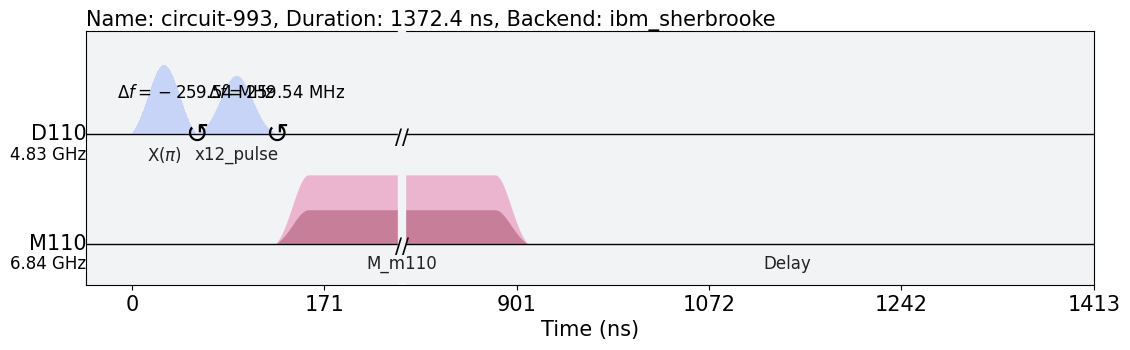

In [153]:
from qiskit import transpile, schedule

schedule = schedule(exp_spect_circs[-1], backend)
schedule.draw(backend=backend)

In [154]:
# excited_freq_sweep_job = backend.run(exp_spect_circs,
#                                      meas_level=1,
#                                      meas_return='avg',
#                                      shots=NUM_SHOTS)

In [155]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev = 50000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit, conv

In [156]:
# excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)
excited_freq_sweep_data = get_job_data(backend.retrieve_job('crkk5pegh8d0008yrjjg'), average=True, qubit = control_qubit)
excited_sweep_freqs = default_qubit_freq + default_anharmonicity*GHz + np.linspace(-50*MHz, 50*MHz, num_freqs)

In [157]:
(excited_sweep_fit_params,
 excited_sweep_y_fit, err) = fit_function(excited_sweep_freqs,
                                     excited_freq_sweep_data,
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, 4.53*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

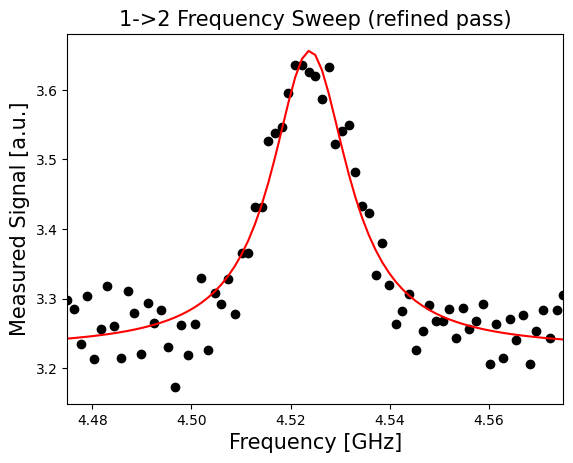

In [158]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.plot(excited_sweep_freqs/GHz, excited_sweep_y_fit, color='red')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [159]:
_, qubit_12_freq, _, _ = excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} +/- {np.sqrt(err[1,1]/GHz**2)} GHz.")
print("The transition frequency from |1> to |2> is  %.4f +/- %.3e" %(excited_sweep_fit_params[1]/GHz, np.sqrt(err[1,1]/GHz**2)))

Our updated estimate for the 1->2 transition frequency is 4.5238572 +/- 0.0003551327575137289 GHz.
The transition frequency from |1> to |2> is  4.5239 +/- 3.551e-04


In [160]:
qubit_frequency_data.append(qubit_12_freq)

Rabi Experiment for |1>->|2>

In [161]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 1.0
x12_duration = 640
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [162]:
amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(control_qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=amp,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [163]:
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(control_qubit+1, control_qubit+1)

qc_rabi.x(control_qubit)
qc_rabi.append(rabi_gate, [control_qubit])
qc_rabi.measure(control_qubit, control_qubit)
qc_rabi.add_calibration(rabi_gate, (control_qubit,), rabi_sched, [amp])
    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]

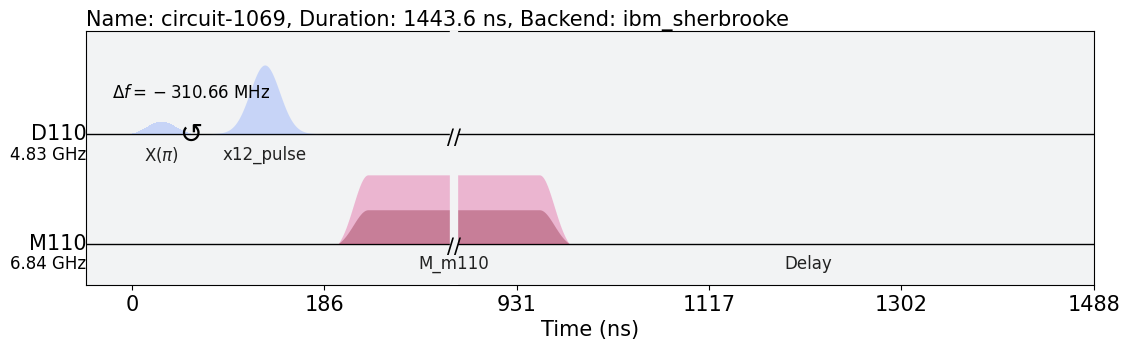

In [164]:
from qiskit import transpile, schedule

schedule = schedule(exp_rabi_circs[-1], backend)
schedule.draw(backend=backend)

In [165]:
# rabi_12_job = backend.run(exp_rabi_circs, 
#                           meas_level=1, 
#                           meas_return='avg', 
#                           shots=NUM_SHOTS)

In [166]:
rabi_12_data = get_job_data(backend.retrieve_job('crkkgw3gh8d0008yrm00'), average=True, qubit = control_qubit)

In [167]:
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

[-0.16966556  3.46115568  0.52927972 -0.21457908]


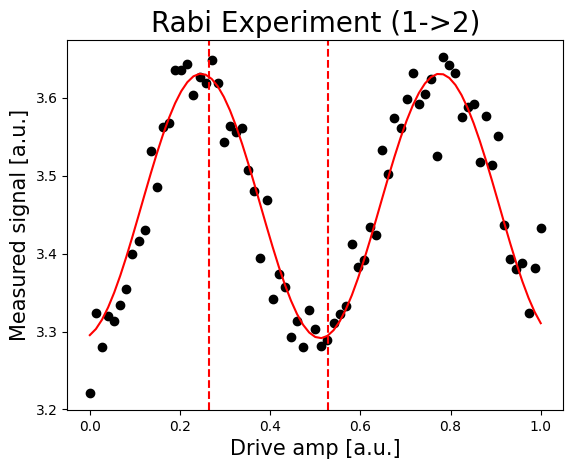

In [168]:
# Note: Only real part of data is plotted
# rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit, err) = fit_function(drive_amps,
                               rabi_12_data, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [0.2, 3.3, 0.5, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')
print(rabi_12_fit_params)
drive_12_period = rabi_12_fit_params[2] 

pi_amp_12 = drive_12_period/2

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [169]:

print(f"Pi Amplitude (1->2) = {pi_amp_12} +/- {np.sqrt(err[2,2]/2)}")

Pi Amplitude (1->2) = 0.2646398579529892 +/- 0.004122943650852532


In [170]:
qubit_pi_pulse_data.append(pi_amp_12)

In [171]:
qubit_frequency_data

[4523857249.057249]

|0>, |1>, |2> Discriminator

In [172]:
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(control_qubit)
    pulse.set_frequency(qubit_frequency_data[0], drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=qubit_pi_pulse_data[0],
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [173]:
# Create the three circuits

# 0 state
qc_ground = QuantumCircuit(control_qubit+1, control_qubit+1)
qc_ground.measure(control_qubit, control_qubit)

# 1 state
qc_one = QuantumCircuit(control_qubit+1, control_qubit+1)
qc_one.x(control_qubit)
qc_one.measure(control_qubit, control_qubit)

# 2 state 
x12_gate = Gate("one_two_pulse", 1, [])
qc_x12 = QuantumCircuit(control_qubit+1, control_qubit+1)
qc_x12.x(control_qubit)
qc_x12.append(x12_gate, [control_qubit])
qc_x12.measure(control_qubit, control_qubit)
qc_x12.add_calibration(x12_gate, (control_qubit,), x12_sched, [])

In [174]:
# Assemble the schedules into a program
# IQ_012_job = backend.run([qc_ground, qc_one, qc_x12], 
#                           meas_level=1, 
#                           meas_return='single', 
#                           shots=NUM_SHOTS)



In [175]:
IQ_012_job = backend.retrieve_job('crkkn2m4r70g0088sjrg')

In [176]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False, qubit = control_qubit)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [177]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_69207/1967918088.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(zero_data), np.imag(zero_data),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_69207/1967918088.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(one_data), np.imag(one_data),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_69207/1967918088.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(two_data), np.imag(two_data),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_69207/1967918088.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_zero), np.imag(mean_zero),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_69207/1967918088.py:20: UserWarning: No

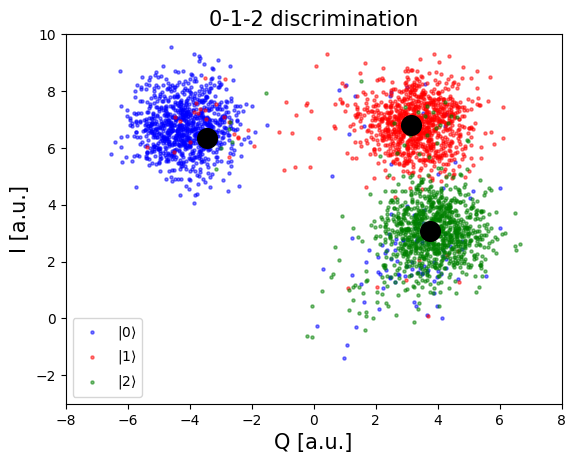

In [178]:
x_min = -8
x_max = 8
y_min = -3
y_max = 10
IQ_012_plot(x_min, x_max, y_min, y_max)

In [179]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [180]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [181]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape) # verify IQ data shape

(3072, 2)


In [182]:
# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
# print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)


In [183]:
classifier = svm.SVC(kernel = 'rbf')
classifier.fit(IQ_012_train, state_012_train)

SVC()

In [184]:
print(classifier.score(IQ_012_train, state_012_train))

0.9466145833333334


In [185]:
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [186]:
print(LDA_012.score(IQ_012_train, state_012_train))

0.9453125


In [187]:
qubit_classifiers.append(classifier)

We now get these same variables for qubit 1

In [188]:
target_qubit = 118

default_qubit_freq = backend_defaults.qubit_freq_est[target_qubit] # Default qubit frequency in Hz.
print(f"Qubit {target_qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[target_qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

Qubit 118 has an estimated frequency of 4.7374765149845315 GHz.
Default anharmonicity is -0.31213784976055814 GHz.


In [189]:
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
    drive_chan = pulse.drive_channel(target_qubit)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=drive_power,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)

In [190]:
sweep_freqs = default_anharmonicity*GHz + np.linspace(-50*MHz, 50*MHz, num_freqs)
spect_gate = Gate("spect", 1, [freq])

qc_spect = QuantumCircuit(target_qubit+1, target_qubit+1)

qc_spect.x(target_qubit)
qc_spect.append(spect_gate, [target_qubit])
qc_spect.measure(target_qubit, target_qubit)
qc_spect.add_calibration(spect_gate, (target_qubit,), freq12_sweep_sched, [freq])


exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]


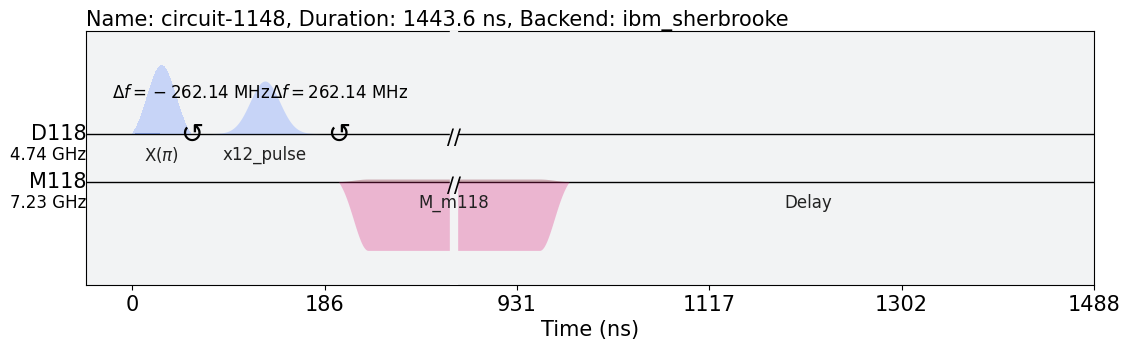

In [191]:
from qiskit import transpile, schedule
# from qiskit.pulse import Schedule, Play, ControlChannel, GaussianSquare

schedule = schedule(exp_spect_circs[-1], backend)
schedule.draw(backend=backend)

In [192]:
# excited_freq_sweep_job = backend.run(exp_spect_circs,
#                                      meas_level=1,
#                                      meas_return='avg',
#                                      shots=NUM_SHOTS)

In [193]:
excited_freq_sweep_data = get_job_data(backend.retrieve_job('crkk650akhw0008ewq20'), average=True, qubit = target_qubit)
excited_sweep_freqs = default_qubit_freq + default_anharmonicity*GHz + np.linspace(-50*MHz, 50*MHz, num_freqs)

Our updated estimate for the 1->2 transition frequency is 4.4246702 +/- 0.0005515227504162925 GHz.


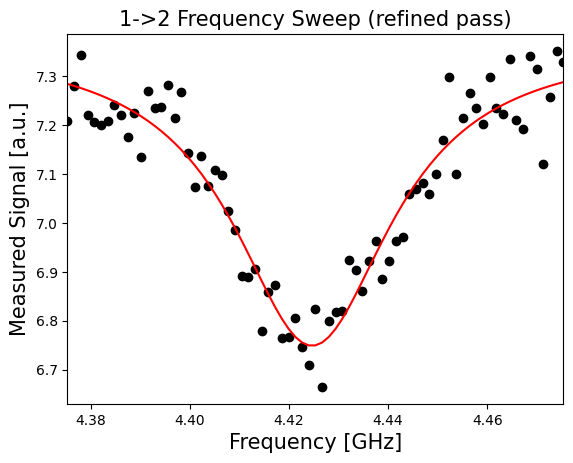

In [194]:
(excited_sweep_fit_params,
 excited_sweep_y_fit, err) = fit_function(excited_sweep_freqs,
                                     excited_freq_sweep_data,
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [20, 4.42*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

# Note: we are only plotting the real part of the signal
_, qubit_12_freq, _, _ = excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} +/- {np.sqrt(err[1,1]/GHz**2)} GHz.")

plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.plot(excited_sweep_freqs/GHz, excited_sweep_y_fit, color='red')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [195]:
qubit_frequency_data.append(qubit_12_freq)

In [196]:
qubit_frequency_data

[4523857249.057249, 4424670166.500501]

In [197]:
amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(target_qubit)
    pulse.set_frequency(qubit_frequency_data[1], drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=amp,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [198]:
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(target_qubit+1, target_qubit+1)

qc_rabi.x(target_qubit)
qc_rabi.append(rabi_gate, [target_qubit])
qc_rabi.measure(target_qubit, target_qubit)
qc_rabi.add_calibration(rabi_gate, (target_qubit,), rabi_sched, [amp])

    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]



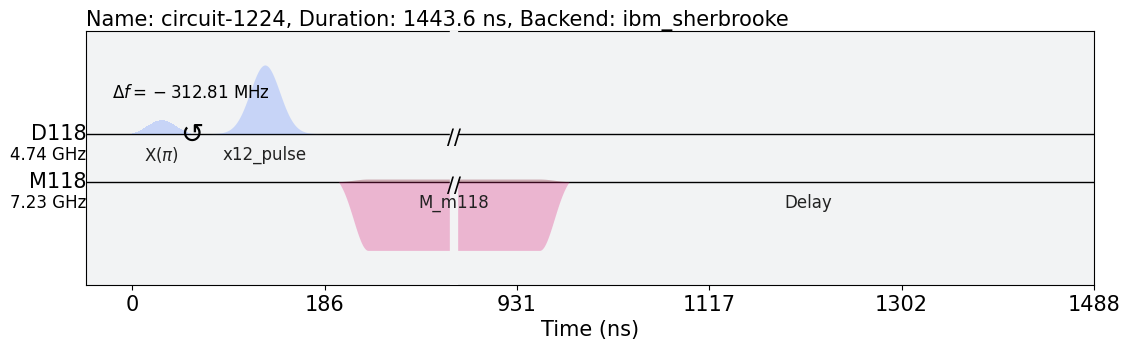

In [199]:
from qiskit import transpile, schedule

rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [200]:
# rabi_12_job = backend.run(exp_rabi_circs, 
#                           meas_level=1, 
#                           meas_return='avg', 
#                           shots=NUM_SHOTS)

In [201]:
rabi_12_data = backend.retrieve_job('crkkhwq4r70g0088sjk0').result()

/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:626: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/homebrew/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


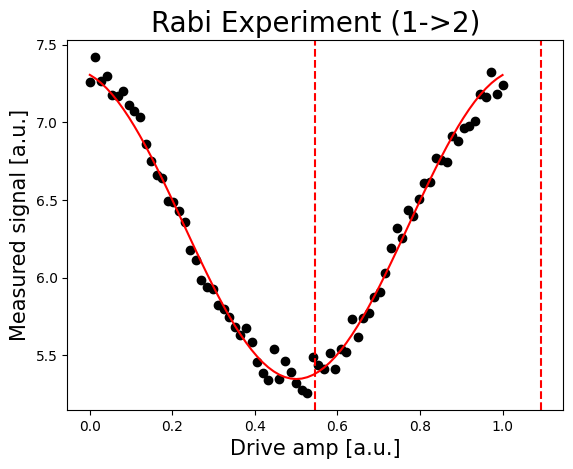

In [202]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_12_data.get_memory(i)[target_qubit] * scale_factor)

# rabi_values = np.real(baseline_remove(rabi_values))
(rabi_12_fit_params, 
 rabi_12_y_fit, err) = fit_function(drive_amps,
                               rabi_values, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [1, 6, 1, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2] 

pi_amp_12 = drive_12_period/2

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [203]:
print(rabi_12_fit_params)

[ 0.99560442  6.34416861  1.09250157 -0.26405645]


In [204]:
print(f"Pi Amplitude (1->2) = {pi_amp_12} +/- {np.sqrt(err[2,2]/2)}")

Pi Amplitude (1->2) = 0.5462507843026214 +/- 0.01630161980241117


In [205]:
qubit_pi_pulse_data.append(pi_amp_12)

In [206]:
print(qubit_frequency_data)
print(qubit_pi_pulse_data)

[4523857249.057249, 4424670166.500501]
[0.2646398579529892, 0.5462507843026214]


In [207]:
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(target_qubit)
    pulse.set_frequency(qubit_frequency_data[1], drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=qubit_pi_pulse_data[1],
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [208]:
# Create the three circuits

# 0 state
qc_ground = QuantumCircuit(target_qubit+1, target_qubit+1)
qc_ground.measure(target_qubit, target_qubit)

# 1 state
qc_one = QuantumCircuit(target_qubit+1, target_qubit+1)
qc_one.x(target_qubit)
qc_one.measure(target_qubit, target_qubit)

# 2 state 
x12_gate = Gate("one_two_pulse", 1, [])
qc_x12 = QuantumCircuit(target_qubit+1, target_qubit+1)
qc_x12.x(target_qubit)
qc_x12.append(x12_gate, [target_qubit])
qc_x12.measure(target_qubit, target_qubit)
qc_x12.add_calibration(x12_gate, (target_qubit,), x12_sched, [])

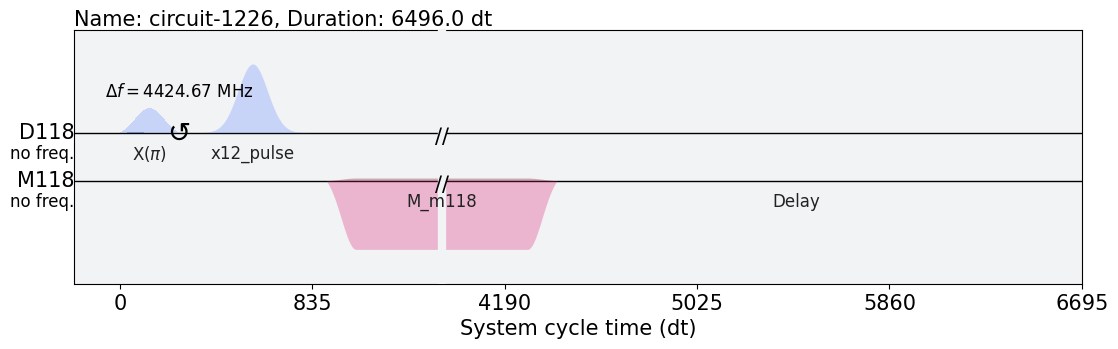

In [209]:
schedule(qc_x12, backend).draw()

In [210]:
# IQ_012_job = backend.run([qc_ground, qc_one, qc_x12], 
#                           meas_level=1, 
#                           meas_return='single', 
#                           shots=1500)

In [211]:
IQ_012_data = get_job_data(backend.retrieve_job('crkkxen14ys000889490'), average=False, qubit = target_qubit)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_69207/1967918088.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(zero_data), np.imag(zero_data),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_69207/1967918088.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(one_data), np.imag(one_data),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_69207/1967918088.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(two_data), np.imag(two_data),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_69207/1967918088.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_zero), np.imag(mean_zero),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_69207/1967918088.py:20: UserWarning: No

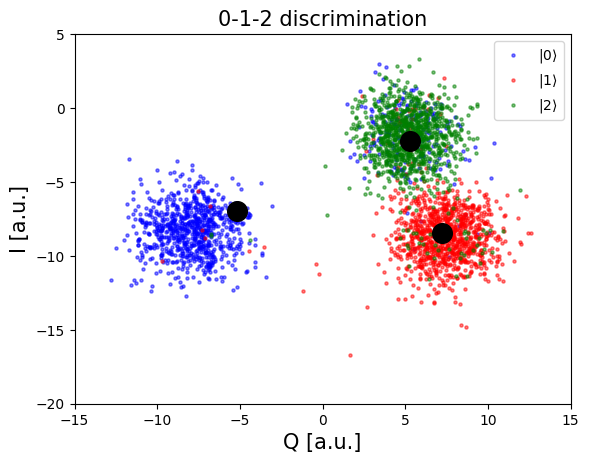

In [212]:
x_min = -15
x_max = 15
y_min = -20
y_max = 5
IQ_012_plot(x_min, x_max, y_min, y_max)

In [213]:
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))

state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
# print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)
classifier = svm.SVC(kernel = 'rbf')
classifier.fit(IQ_012_train, state_012_train)
print(classifier.score(IQ_012_train, state_012_train))

0.892578125


In [214]:
qubit_classifiers.append(classifier)

In [215]:
qubit_classifiers

[SVC(), SVC()]

In [269]:
basis_gates

['id', 'rz', 'sx', 'x', 'ecr', 'reset', 'spect']

In [5]:
qc = QuantumCircuit(2,2)
# qc.h(0)
# qc.barrier()
qc.rzx(np.pi/4,1,0)
qc.decompose().draw()
# circ = transpile(qc, backend=backend)
# sched = schedule(circ, backend=backend)
# print(sched)
# sched.draw()

┌───┐┌───┐┌─────────┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ H ├
     └───┘└─┬─┘└─────────┘└─┬─┘└───┘
q_1: ───────■───────────────■───────
                                    
c: 2/═══════════════════════════════

In [218]:
wave = inst_map.get('ecr', qubits = (110,118))
print(wave)

Schedule((0, Play(GaussianSquare(duration=1072, sigma=64, width=816, amp=0.08117606741074938, angle=0.030697600177919716, name='CR90p_d118_u253'), DriveChannel(118), name='CR90p_d118_u253')), (0, Play(GaussianSquare(duration=1072, sigma=64, width=816, amp=0.22923628173455912, angle=2.64293777967187, name='CR90p_u253'), ControlChannel(253), name='CR90p_u253')), (1072, Play(Drag(duration=256, sigma=64, beta=0.05054171299023734, amp=0.17667327456459958, angle=0.0, name='Xp_d110'), DriveChannel(110), name='Xp_d110')), (1328, Play(GaussianSquare(duration=1072, sigma=64, width=816, amp=0.08117606741074938, angle=-3.110895053411874, name='CR90m_d118_u253'), DriveChannel(118), name='CR90m_d118_u253')), (1328, Play(GaussianSquare(duration=1072, sigma=64, width=816, amp=0.22923628173455915, angle=-0.4986548739179233, name='CR90m_u253'), ControlChannel(253), name='CR90m_u253')), name="ecr")


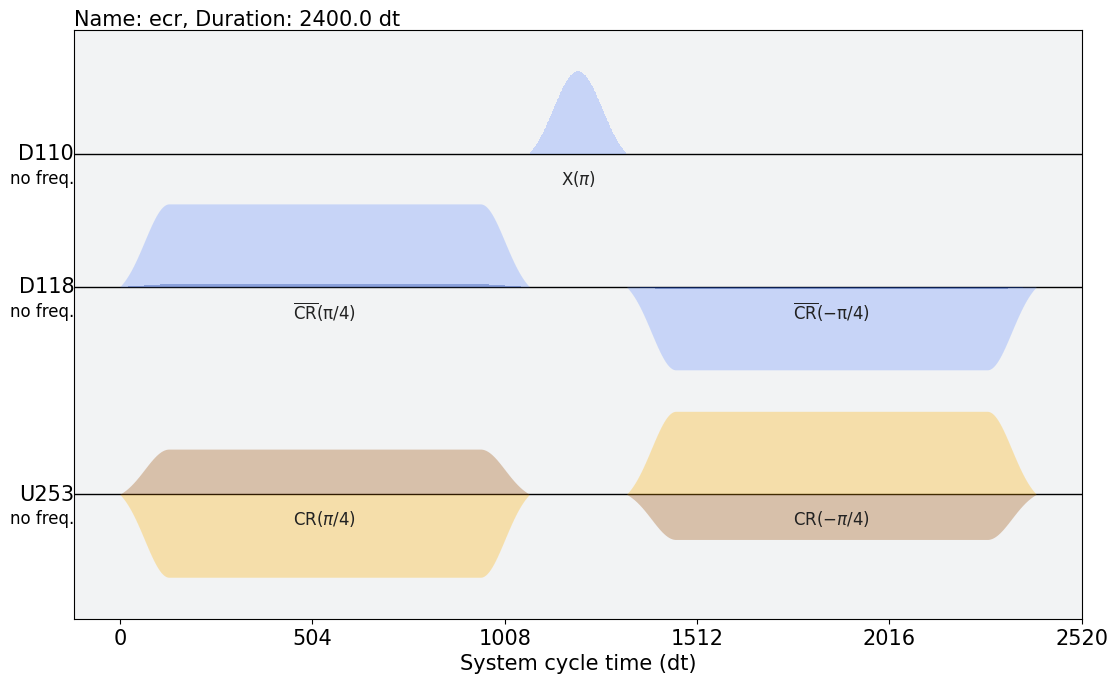

In [219]:
wave.draw()

In [38]:
inst_map.get('x', qubits = [0])

Schedule((0, Play(Drag(duration=256, sigma=64, beta=3.267791342874729, amp=0.19913181945286054, angle=0.0, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="x")